<a href="https://colab.research.google.com/github/leoalexandre/mvp_adbp/blob/main/mvp_anp_seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Análise de Dados e Boas Práticas
Por Leonardo da Silva Alexandre

## 1.   Definição do Problema

O dataset utilizado neste projeto foi retirado do site da Agência Nacional do Petróleo (ANP). A criação veio a partir da tabela de atributos retirada do shapefile de todos os programas sísmicos gerados pelo mercado de óleo e gás brasileiro, somado a aplicação de algumas regras presentes na legislação brasileira gerida pela ANP. A legislação nacional pode ser encontrada dentro dos sites da ANP. O shapefile está alocado mais precisamente em:

https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/dados-tecnicos/acervo-de-dados

O dataset apresenta atributos relacionados aos programas sísmicos com relação a datas, localização, volume, valor, empresas proprietárias dos dados e período de confidencialidade. Seu objetivo é vislumbrar novos processamentos ou aquisições sísmicas com maior potencial de interesse do mercado a partir da identificação de uma ausência de dados de processamento, e suas versões, em áreas das bacias sedimentares brasileiras que apresentem maior visibilidade da indústria de óleo e gás.
Dentro de um cenário fictício, uma empresa de processamento sísmico utilizará as informações para identificar um programa sísmico que teria maior relevância para ser processado ou reprocessado. Para isso, será necessário levar em consideração o cenário atual da exploração de petróleo no Brasil para classificar as informações. Estas classificações poderiam posteriormente ser modificadas pelo próprio cenário do mercado de óleo e gás brasileiro ou a pedido de um potencial cliente.

Informações sobre atributos:

  1. **Vol_GB** – Volume da soma dos arquivos do projeto sísmico;
  2. **UDs** – Valor em UD do projeto sísmico;
  3. **Project** – Projeto sísmico oriundo de um programa sísmico;
  4. **Type_Proc** – Tipo de processamento sísmico realizado no programa sísmico;
  5. **Pub** – Classificação do programa sísmico em público ou confidencial;
  6. **Program** – Programa sísmico criado pela ANP por solicitação da empresa;
  7. **Type_Prog** – Classificação do programa sísmico em Exclusivo (Pré-98), Exclusivo, Não-Exclusivo ou de fomento;
  8. **Dim** – Dimensionalidade do dado sísmico;
  9. **date_start** – Data de início do programa;
  10. **date_end** – Data de término do programa;
  11. **time** - Tempo de existência do programa;
  12. **date_pub** – Data na qual o programa se torna público perante a legislação vigente;
  13. **Bloc** – Bloco exploratório onde está localizado o programa sísmico;
  14. **Field** – Campo de exploração onde está localizado o programa sísmico;
  15. **Basin** – Bacia geológica onde está localizado o programa sísmico;
  16. **EAD** – Empresa de Aquisição de Dados responsável pelo programa sísmico;
  17. **Operator** – Empresa Operadora detentora dos direitos sobre os dados do programa sísmico.

In [19]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from IPython.display import display
from statistics import mean

In [3]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Carga de Dados

Para a carga dos dados presentes em um arquivo de extensão csv será utilizado o pacote Pandas (Python Data Analysis Library). O arquivo se encontra armazenado na pasta pública no GitHub e será carregado diretamente do local. Um novo cabeçalho será inserido acompanhando a descrição prévia dos atributos. Após o carregamento do dataset realizado, os dados serão expostos para uma análise inicial.

In [8]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/leoalexandre/mvp_adbp/main/dados_anp_versao_MVP.csv"

# Informa o cabeçalho das colunas
colunas = ['Vol_GB', 'UDs', 'Project', 'Type_Proc', 'Pub', 'Program', 'Type_Prog', 'Dim', 'date_start','date_end', 'time', 'date_pub', 'Bloc', 'Field', 'Basin', 'EAD', 'Operator']

# Lê o arquivo utilizando as colunas informadas
dados_anp = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')


A seguir será exibida a parte inicial da tabela onde é possível visualizar uma pequena amostra dos dados e o novo cabeçalho.

In [ ]:
# Mostra a parte inicial do dataset e seus atributos
dados_anp.head()

,Vol_GB,UDs,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,EAD,Operator
0,0.016620,1.000000,0007_SERGIPE_ALAGOAS_39,STK FIN,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
1,NaN,NaN,0007_SERGIPE_ALAGOAS_39,Field Data,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
2,18.291451,3.658290,0022_BRASILSPAN01_PSDM,MIG PSDM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
3,14.677270,2.935454,0022_BRASILSPAN01_PSTM,MIG PSTM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
4,4283.437811,42.834378,0022_BRASILSPAN01,Field Data,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN


## 3. Análise dos Dados

### 3.1 Estatísticas Descritivas

A análise inicial dos dados parte da visualização das dimensões do dataset, seguido das informações dos atributos e amostras de parte dos dados em tabelas.

In [ ]:
# Mostra as dimensões do dataset
print(dados_anp.shape)

(5783, 17)


In [ ]:
# Mostra as informações do dataset
print(dados_anp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Vol_GB      4643 non-null   float64
 1   UDs         4643 non-null   float64
 2   Project     5783 non-null   object 
 3   Type_Proc   5783 non-null   object 
 4   Pub         5783 non-null   object 
 5   Program     5783 non-null   object 
 6   Type_Prog   5783 non-null   object 
 7   Dim         5783 non-null   object 
 8   date_start  5783 non-null   object 
 9   date_end    5783 non-null   object 
 10  time        5783 non-null   int64  
 11  date_pub    5783 non-null   object 
 12  Bloc        5783 non-null   object 
 13  Field       5783 non-null   object 
 14  Basin       5782 non-null   object 
 15  EAD         5783 non-null   object 
 16  Operator    4239 non-null   object 
dtypes: float64(2), int64(1), object(14)
memory usage: 768.2+ KB
None


In [ ]:
# Mostra as 10 primeiras linhas do dataset
dados_anp.head(10)

,Vol_GB,UDs,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,EAD,Operator
0,0.016620,1.000000,0007_SERGIPE_ALAGOAS_39,STK FIN,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
1,NaN,NaN,0007_SERGIPE_ALAGOAS_39,Field Data,Publico,0007_SERGIPE_ALAGOAS_39,Exclusivo Pre-98,Sismica 2D,08/05/1970,23/08/1970,53,,,,multiplas,Petrobras,Petrobras
2,18.291451,3.658290,0022_BRASILSPAN01_PSDM,MIG PSDM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
3,14.677270,2.935454,0022_BRASILSPAN01_PSTM,MIG PSTM,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
4,4283.437811,42.834378,0022_BRASILSPAN01,Field Data,Confidencial,0022_BRASILSPAN01,Nao-Exclusivo,Sismica 2D,17/05/2007,21/06/2008,15,21/06/2026,,,multiplas,GX Technology,NaN
5,48.240106,9.648021,0022_GREATERBRASILSPAN,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
6,9.820742,1.964148,0022_GREATERBRASILSPAN_SUBSET1,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
7,3.920684,1.000000,0022_GREATERBRASILSPAN_SUBSET2,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
8,16.461309,3.292262,0022_GREATERBRASILSPAN_SUBSET4,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN
9,13.980689,2.796138,0022_GREATERBRASILSPAN_SUBSET5,PSDM,Confidencial,0022_GREATERBRASILSPAN,Nao-Exclusivo,Sismica 2D,03/10/2008,31/08/2012,11,31/08/2030,,,multiplas,GX Technology,NaN


In [ ]:
# Mostra as 10 últimas linhas do dataset
dados_anp.tail(10)

,Vol_GB,UDs,Project,Type_Proc,Pub,Program,Type_Prog,Dim,date_start,date_end,time,date_pub,Bloc,Field,Basin,EAD,Operator
5773,1.022351,1.0,R0392_BC10_LOFS_2016_4D_SC0360_M3,PSDM,Publico,R0392_BC10_LOFS_2016_4D_SC0360,Exclusivo,Sismica 3D,28/04/2016,17/11/2016,7,17/11/2021,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5774,0.292222,1.0,R0392_BC10_LOFS_2018_4D_BS,PSDM,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5775,0.292222,1.0,R0392_BC10_LOFS_2018_4D_M3,PSDM,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5776,0.292222,1.0,R0392_BC10_LOFS_2018_4D_M4,PSDM,Publico,R0392_BC10_LOFS_2018_4D,Exclusivo,Sismica 3D,01/06/2018,20/06/2018,5,20/06/2023,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5777,0.600385,1.0,R0392_BC10_LOFS_2020_4D_BS,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5778,0.600385,1.0,R0392_BC10_LOFS_2020_4D_M5,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5779,1.014275,1.0,R0392_BC10_LOFS_2020_4D_M5_DEPTH_ALIGNED,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5780,1.014275,1.0,R0392_BC10_LOFS_2020_4D_M5_DEPTH_SHIFT,PSDM,Confidencial,R0392_BC10_LOFS_2020_4D,Exclusivo,Sismica 3D,24/01/2020,31/05/2020,3,31/05/2025,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5781,1.022351,1.0,R0392_BC10_LOFS_BASELINE,PSDM,Publico,R0392_BC10_LOFS_BASELINE,Exclusivo,Sismica 3D,12/10/2013,30/05/2014,9,30/05/2019,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil
5782,1.022351,1.0,R0392_BC10_LOFS_BASELINE,PSDM,Publico,R0392_BC10_LOFS_BASELINE,Exclusivo,Sismica 3D,12/10/2013,30/05/2014,9,30/05/2019,BC-10,ARGONAUTA,Campos,Shell Brasil,Shell Brasil


In [ ]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dados_anp.describe()

,Vol_GB,UDs,time
count,4643.000000,4643.000000,5783.000000
mean,532.476506,11.941088,18.468615
std,8273.903989,84.314077,16.262781
min,0.000053,1.000000,0.000000
25%,0.366224,1.000000,5.000000
50%,5.219403,1.000000,11.000000
75%,26.434310,4.700951,29.000000
max,299061.045400,2990.610454,54.000000


Vamos comparar as informações agora separando os dados em dois dataset, um apenas com os dados brutos e outro com os dados processados.

Essa comparação é extremamente relevante que seja feita pois é de conhecimento dentro do mercado de óleo e gás que o volume dos dados brutos é normalmente consideravelmente superior aos dados processados.

In [34]:
# Criando dataset alternativo sem a presença dos dados Brutos
df_s_fd= dados_anp.loc[dados_anp['Type_Proc'] != 'Field Data']

# Criando dataset alternativo apenas com dados Brutos
df_c_fd= dados_anp.loc[dados_anp['Type_Proc'] == 'Field Data']

# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
df_s_fd.describe()

,Vol_GB,UDs,time
count,4470.000000,4470.000000,4517.000000
mean,42.132627,7.273900,15.660837
std,158.219959,18.483940,15.591414
min,0.000053,1.000000,0.000000
25%,0.334934,1.000000,4.000000
50%,4.073957,1.000000,8.000000
75%,23.411641,4.682328,23.000000
max,4251.282431,425.128243,54.000000


In [35]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
df_c_fd.describe()

,Vol_GB,UDs,time
count,173.000000,173.000000,1266.000000
mean,13202.055344,132.532588,28.486572
std,40978.111952,409.617634,14.575475
min,0.090527,1.000000,3.000000
25%,8.953761,1.000000,16.000000
50%,65.244905,1.000000,26.000000
75%,2613.446031,26.134460,41.000000
max,299061.045400,2990.610454,54.000000


Agora vamos observar a distribuição das classes de maior importância para a resolução do problema inicial. Essas informações serão futuramente expostas e classificadas para a melhor manipulação e entendimento dos dados.

In [ ]:
# Mostra a distribuição das classes de acordo com o tipo de processamento
print(dados_anp.groupby('Type_Proc').size())

Type_Proc
                        36
Field Data            1266
MIG FIN                688
MIG PRE-STK 3D RAW       1
MIG PRE-STK RAW          2
MIG PSDM                35
MIG PSTM               108
MIG PSTM C-WAVE          5
MIG RAW                 54
MIG VEL                  8
Other                  119
POST-STM               210
POSTSDM                  1
PSDM                  1886
PSTM                   887
STK FIN                445
STK RAW                 32
dtype: int64


In [ ]:
# Mostra a distribuição das classes de acordo com a publicidade dos dados
print (dados_anp.groupby('Pub').size())

Pub
Confidencial    1956
Publico         3827
dtype: int64


In [ ]:
# Mostra a distribuição das classes de acordo com a dimensionalidade dos dados
print (dados_anp.groupby('Dim').size())

Dim
Sismica 2D    2336
Sismica 3D    3429
Sismica_2D       7
Sismica_3D      11
dtype: int64


In [ ]:
# Mostra a distribuição dos dados de acordo com a bacia sedimentar onde está localizado cada programa
print (dados_anp.groupby('Basin').size())

Basin
                           2
Acre                      20
Alagoas                   83
Almada                     1
Amazonas                 112
Araripe                    2
Barreirinhas              67
Camamu                    66
Campos                  1442
Ceara                    126
Cumuruxatiba              51
Espirito Santo           410
Foz do Amazonas          140
Jacuipe                   16
Jatoba                     4
Jequitinhonha             82
Madre de Dios              4
Marajo                     8
Mucuri                    30
Para - Maranhao           97
Parana                    95
Parecis - Alto Xingu      13
Parnaiba                 169
Pelotas                   65
Pernambuco - Paraiba      23
Potiguar                 503
Reconcavo                320
Rio do Peixe              11
Santos                   894
Sao Francisco             41
Sao Luis                   9
Sergipe                  246
Solimoes                 178
Tacutu                    10
Taubate 

Nas observações realizadas foi possível identificar alguns pontos onde será necessária a realização de ajustes nos dados. Como exemplo desses ajustes podemos elencar alguns dos problemas de ausência de informações no atributo relacionado as bacias sedimentares e ao tipo de processamento. Foi possível observar também problemas com relação a nomenclatura, tanto do atributo de dimensionalidade quanto a nomenclatura do tipo de processamento. Algumas informações de mesmo significado encontram-se com a nomenclatura escrita de forma diferente e precisarão ser corrigidas na etapa de pré-processamento.

### 3.2 Visualizações Unimodais

Dentro dos atributos mais relevantes para o projeto, foram geradas algumas visualizações gráficas para o entendimento da distribuição dos dados. É observado nas distribuições com relação a quantidade de programas vinculados a bacia, tipo de processamento ou idade do programa o comportamento exponencial dos gráficos.

Text(0, 0.5, 'Qtd Projetos')

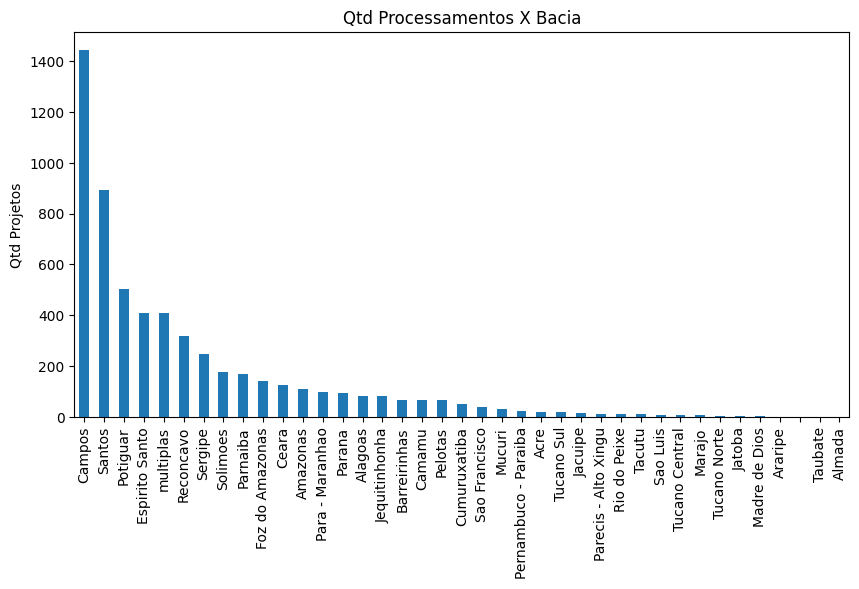

In [ ]:
#Plotando a quantidade de processamentos existente em cada bacia sedimentar
df_bacias = dados_anp['Basin'].value_counts()
df_bacias.plot(kind= 'bar', figsize=(10,5))
plt.title('Qtd Processamentos X Bacia')
plt.ylabel('Qtd Projetos')

As bacias de Campos e Santos, reconhecidamente as mais produtivas no Brasil, justificam a quantidade de projetos inseridos em suas áreas. O investimento superior a bacias de menor expressão em termos de potencial exploratório também é evidenciado pelo gráfico se conectarmos a quantidade de projetos sísmicos realizados com o nível de investimento financeiro na área.

Text(0, 0.5, 'Qtd Projetos')

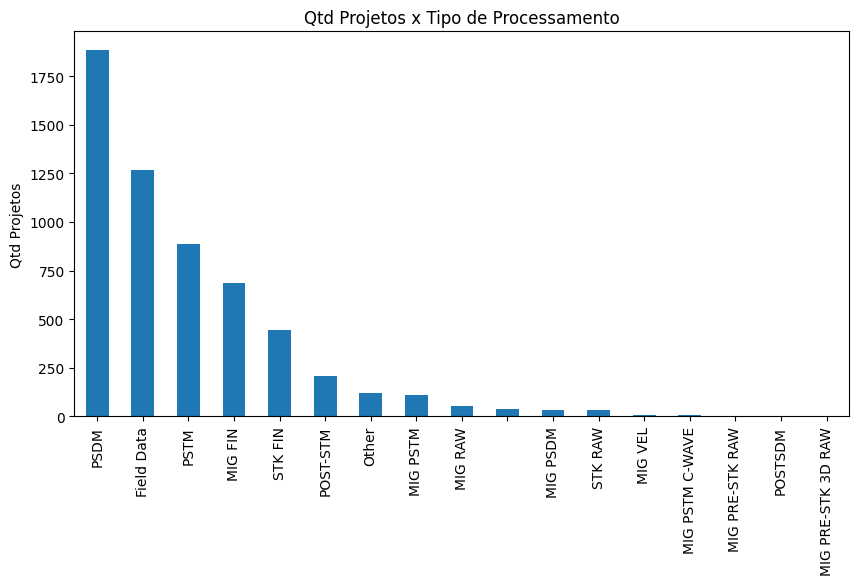

In [ ]:
#Plotando a quantidade de tipos de processamentos
df_tipos = dados_anp['Type_Proc'].value_counts()
df_tipos.plot(kind= 'bar', figsize=(10,5))
plt.title('Qtd Projetos x Tipo de Processamento')
plt.ylabel('Qtd Projetos')

Text(0, 0.5, 'Qtd Projetos')

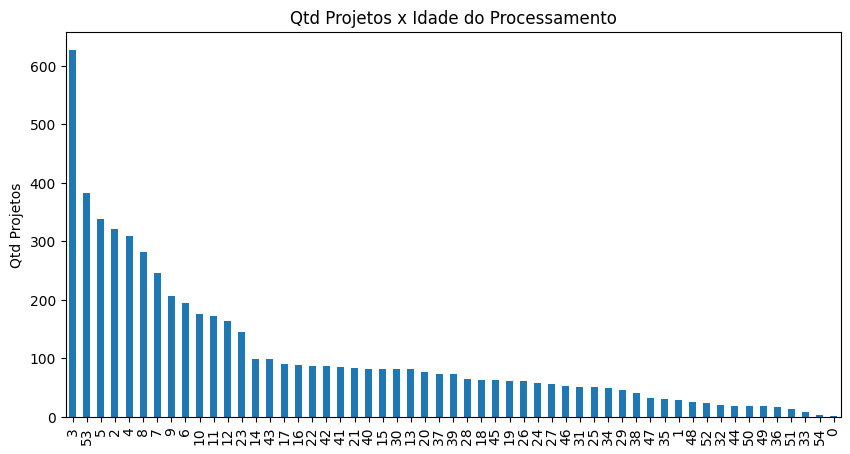

In [ ]:
#Plotando grafico de idade dos programas
df_idade = dados_anp['time'].value_counts()
df_idade.plot(kind= 'bar', figsize=(10,5), )
plt.title('Qtd Projetos x Idade do Processamento')
plt.ylabel('Qtd Projetos')

O comportamento da distribuição seja por bacia ou tipo de processamento e até mesmo do tempo de existência do projeto é bastante similar. Com relação ao tipo de processamento e bacia, o gráfico demonstra uma preferência pelas bacias de Campos e Santos. O tipo de processamento mais presente no dataset é o PSDM, que de fato é o produto final necessário para a alocação de um poço exploratório.
A distribuição de acordo com o tempo de existência do programa exibe um pouco da história da exploração brasileira de petróleo, podendo ser observado os anos em que tivemos mais investimento ou menos e até o início de tudo com os primeiros projetos sísmicos.

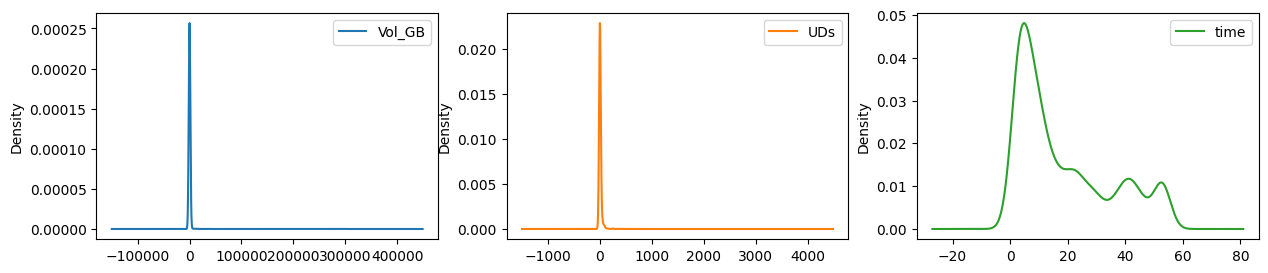

In [ ]:
# Density Plot
dataset.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

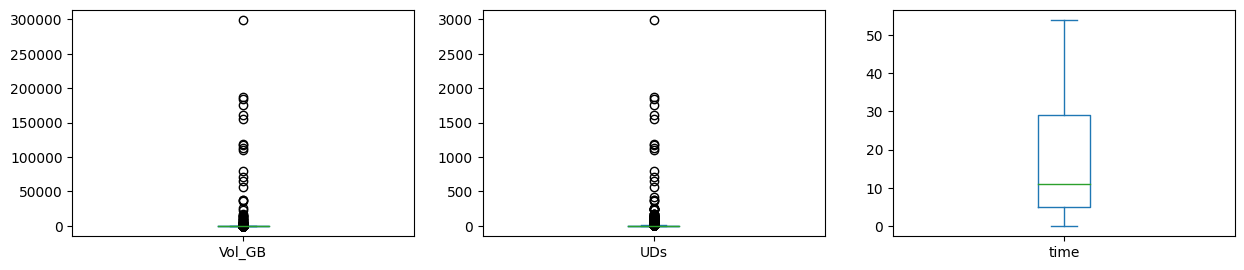

In [ ]:
# Boxplot
dataset.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

O gráfico de densidade, assim como o boxplot expõem a falta de padrão no quesito de valor ou volume dos dados. Esse comportamento é esperado devido a complexidade que os dados sísmicos tem em relação ao volume.
O volume dos dados vem crescendo considerávelmente com a chegada de nova tecnologias de aquisição sísmica e com o aumento da capacidade de armazenamento dos bancos de dados das empresas. Apesar de se assemelhar a um outlier uma discrepância de volume ou valor é natural neste tipo de dado.
Como o valor do dado na ANP é diretamente proporcional ao volume do mesmo, era previsível também que o comportamento das UDs fosse identico ao do volume.
A distribuição de acordo com o tempo de existência do programa desenha uma noção do crescimento da geração de dados sísmicos no Brasil nos últimos ano. Apesar da presença de projetos muito antigos a mediana mostra que o histórico recente é de maior criação de dados sísmicos no território nacional.

### 3.3 Visualizações Multimodais

Exiberemos agora uma matriz de correlação e dados de Scater Plot, para que seja possível mais alguma análise sobre o dataset da ANP.

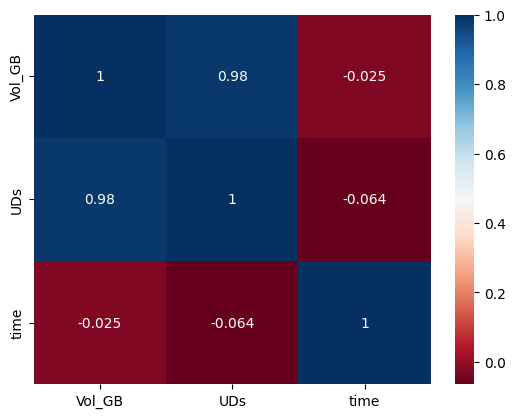

In [ ]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(dataset.corr(), annot=True, cmap='RdBu');

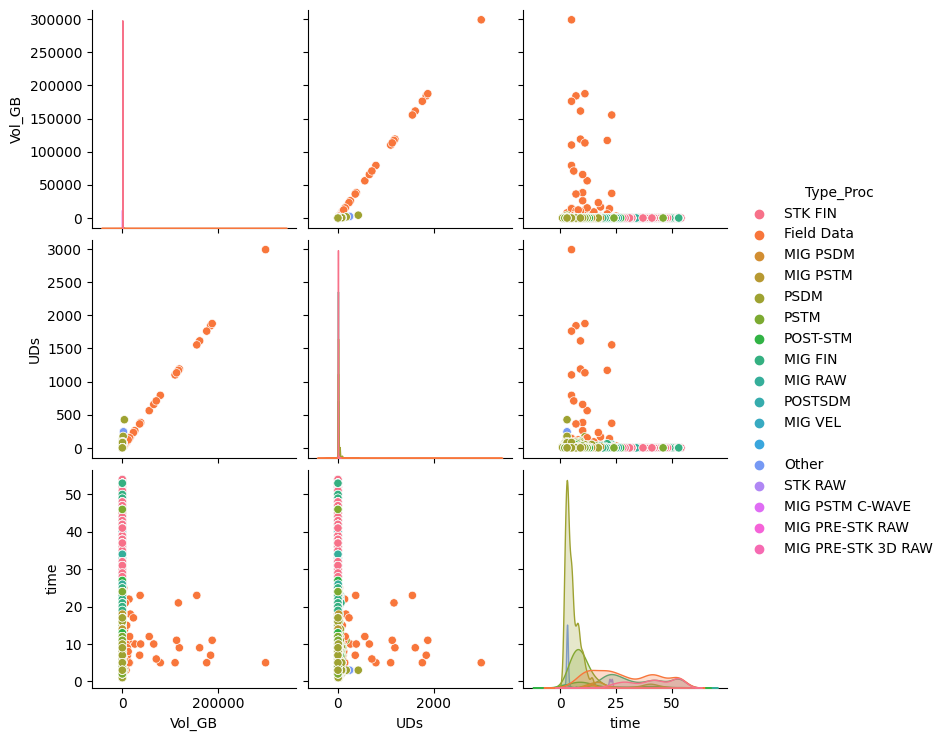

In [ ]:
# Scatter Plot com Seaborn - Variação 1

sns.pairplot(dataset, hue = "Type_Proc", height = 2.5);

A matriz de correlação, juntamente com as retas diagonais presentes no Scater Plot, evidencia mais uma vez como os dados de volume e valor estão diretamente ligados, enquanto o tempo de existência do programa não apresenta uma conexão clara com nenhum dos outros atributos expostos. A retas diagonais nos gráficos são explicadas pela regra de definição de valor dos projetos na ANP, que leva em consideração apenas o volume dos dados.

Como existe normalmente uma diferença entre dados brutos (Field Data) e dados processados, faremos uma divisão no dataset para tentar observar diferenças no comportamento dos dados.

A **variação 2** trará o dataset **sem** os dados brutos (**Field Data**), enquanto a **variação 3** trará o dataset **apenas** com os dados brutos (**Field Data**).

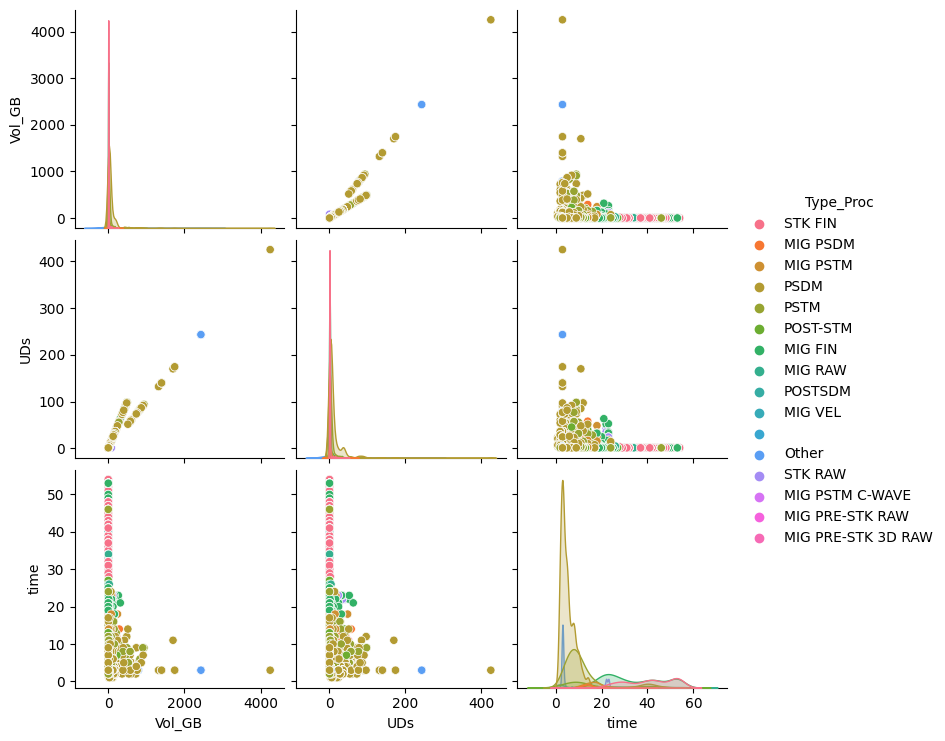

In [32]:
# Scatter Plot com Seaborn - Variação 2
sns.pairplot(df_s_fd, hue = "Type_Proc", height = 2.5);

Conforme mensionado anteriormente, a ANP leva em consideração apenas o volume dos dados para a definição do valor, com isso não percebemos nenhuma informação significativa nos dados ligados a volume e valor.

Com relação ao tempo percebemos como os dados PSDM e PSTM estão mais presentes em projetos mais novos. É interessante pois são dados que exigem mais infra-estrutura tecnológica, o que vem evoluindo com o tempo, exatamente como evidencia o gráfico.

In [24]:
# Scatter Plot com Seaborn - Variação 3
sns.pairplot(df_c_fd, hue = "Type_Proc", height = 2.5);

Os Field Data são os dados gerados diretamente pela aquisição sísmica. Observando os resultados expostos com relação aos dados brutos (Field Data) é possível verificar no tempo uma queda atual na aquisição sísmica, porém no decorrer dos anos anteriores a atividade se mostrou bastante estável.

## 4. Pré-Processamento de Dados

Na etapa de pré-processamento dos dados serão trabalhado faremos os ajustes de nomenclatura indicados durante as análises dos dados, trataremos das informações faltantes CONTINUAR

In [9]:
# salvando um NOVO dataset para tratamento

# recuperando os nomes das colunas
col = list(dados_anp.columns)

# o novo dataset será identico ao dataset anterior
programas = dados_anp[col[:]]

### 4.1 Tratamento das informações textuais

Na parte de análise dos dados foram verificadas algumas falhas textuais e conceituais dentro do dataset, para solucionar o problema foi necessária a criação de uma seção para realizar os ajustes textuais. Esses ajustes serão realizados com base em conhecimento prévio sobre o banco de dados sísmicos.

In [11]:
# Ajustando a nomenclatura do atributo de tipo de processamento
programas['Type_Proc'] = programas['Type_Proc'].replace(['MIG PRE-STK 3D RAW', 'MIG PRE-STK RAW', 'MIG PSTM C-WAVE', 'POSTSDM'], ['MIG RAW', 'MIG RAW', 'MIG PSTM', 'POST-SDM'])

# Exibindo a distribuição das classes de acordo com o tipo de processamento dos dados corrigido
print (programas.groupby('Type_Proc').size())

Type_Proc
                36
Field Data    1266
MIG FIN        688
MIG PSDM        35
MIG PSTM       113
MIG RAW         57
MIG VEL          8
Other          119
POST-SDM         1
POST-STM       210
PSDM          1886
PSTM           887
STK FIN        445
STK RAW         32
dtype: int64


In [13]:
# Ajustando a nomenclatura do atributo de tipos de processamento
programas['Dim'] = programas['Dim'].replace(['Sismica_2D', 'Sismica_3D'], ['Sismica 2D', 'Sismica 3D'])

# Mostrando a distribuição das classes de acordo com a dimensionalidade dos dados corrigida
print (programas.groupby('Dim').size())

Dim
Sismica 2D    2343
Sismica 3D    3440
dtype: int64


As nomenclaturas foram ajustadas e padronizadas.

### 4.2 Tratamento de Missings e Limpeza

Iniciaremos a limpeza e os tratamentos nos atributos com informações faltantes.

In [14]:
# verificando nulls no dataset
programas.isnull().sum()

Vol_GB        1140
UDs           1140
Project          0
Type_Proc        0
Pub              0
Program          0
Type_Prog        0
Dim              0
date_start       0
date_end         0
time             0
date_pub         0
Bloc             0
Field            0
Basin            1
EAD              0
Operator      1544
dtype: int64

<Axes: >

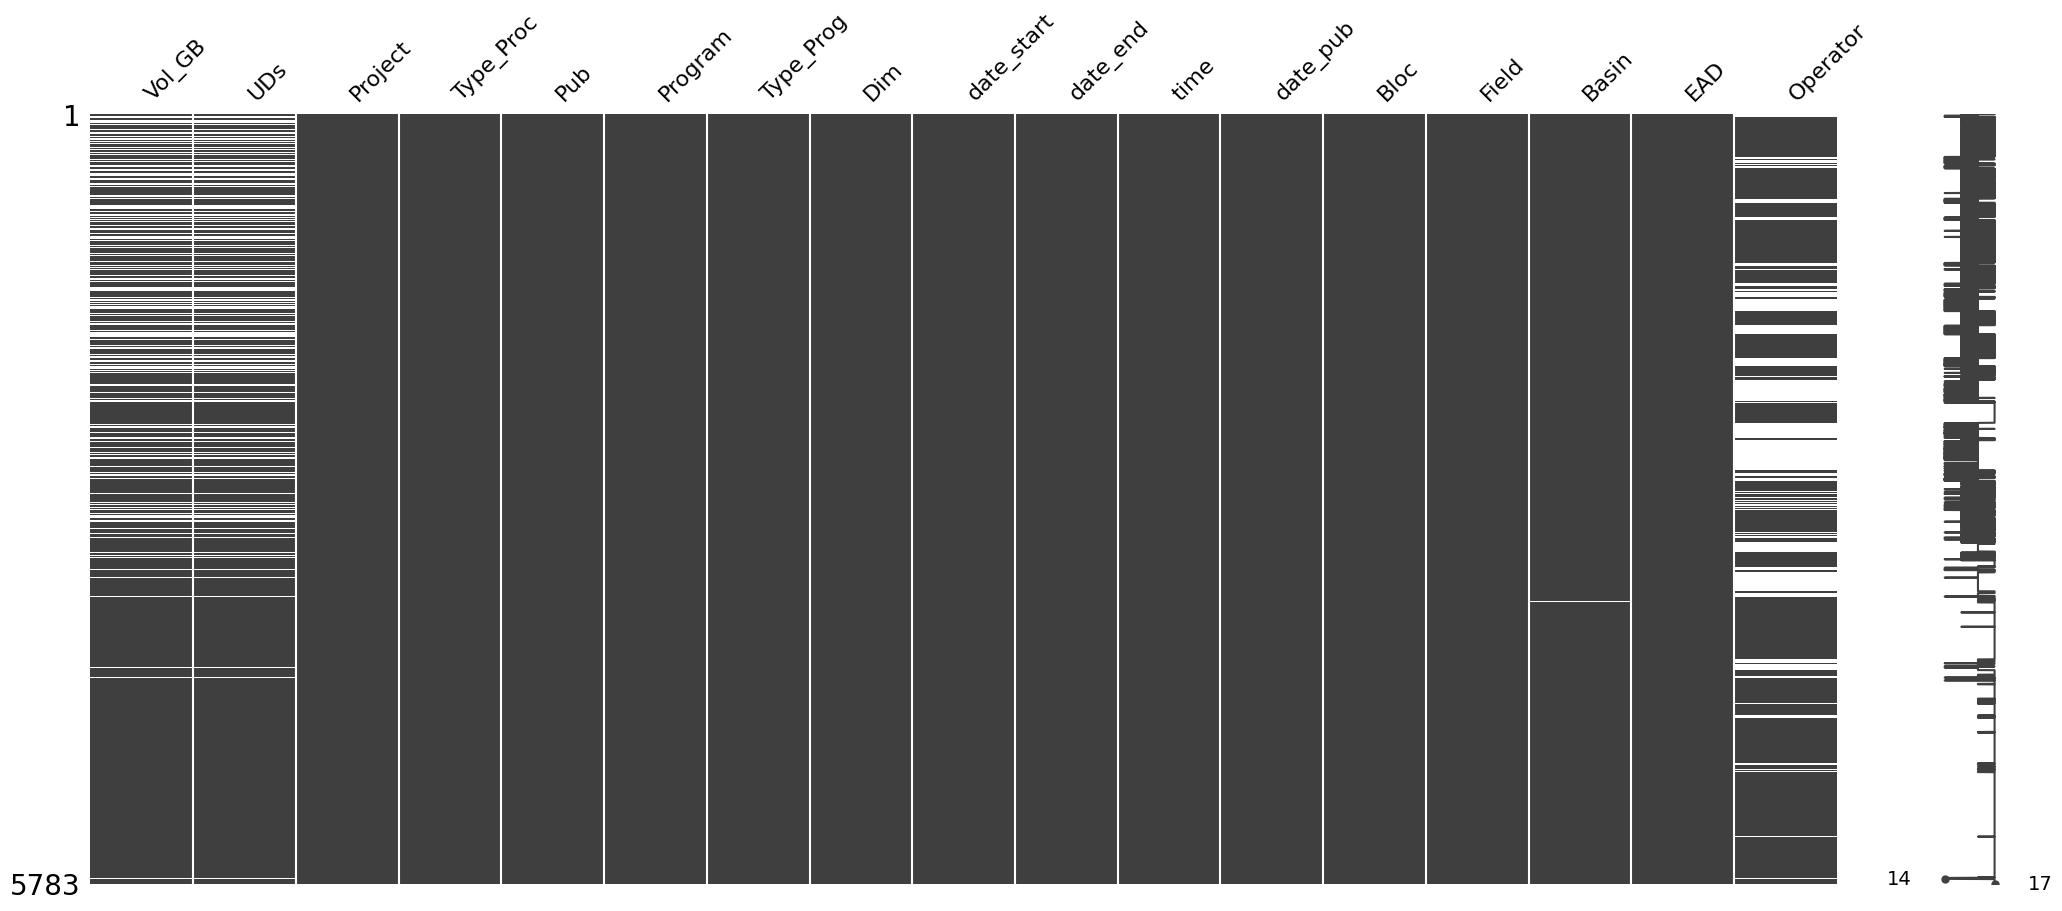

In [15]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(programas)

Existem muitas informações faltante nas colunas de volume e valor dos dados na ANP, além da ausência de Operadoras.

Alguns programas são realizados por iniciativa das EAD, logo dados com ausência de Operadoras são recorrentes e não representam um problema, mas sim uma situação normal do mercado.

Os dados de valor não serão importantes nas tomadas de decisão pois fazem parte de uma atribuição da ANP que é diretamente proporcional ao volume, logo as informações de valor serão removidas.

<Axes: >

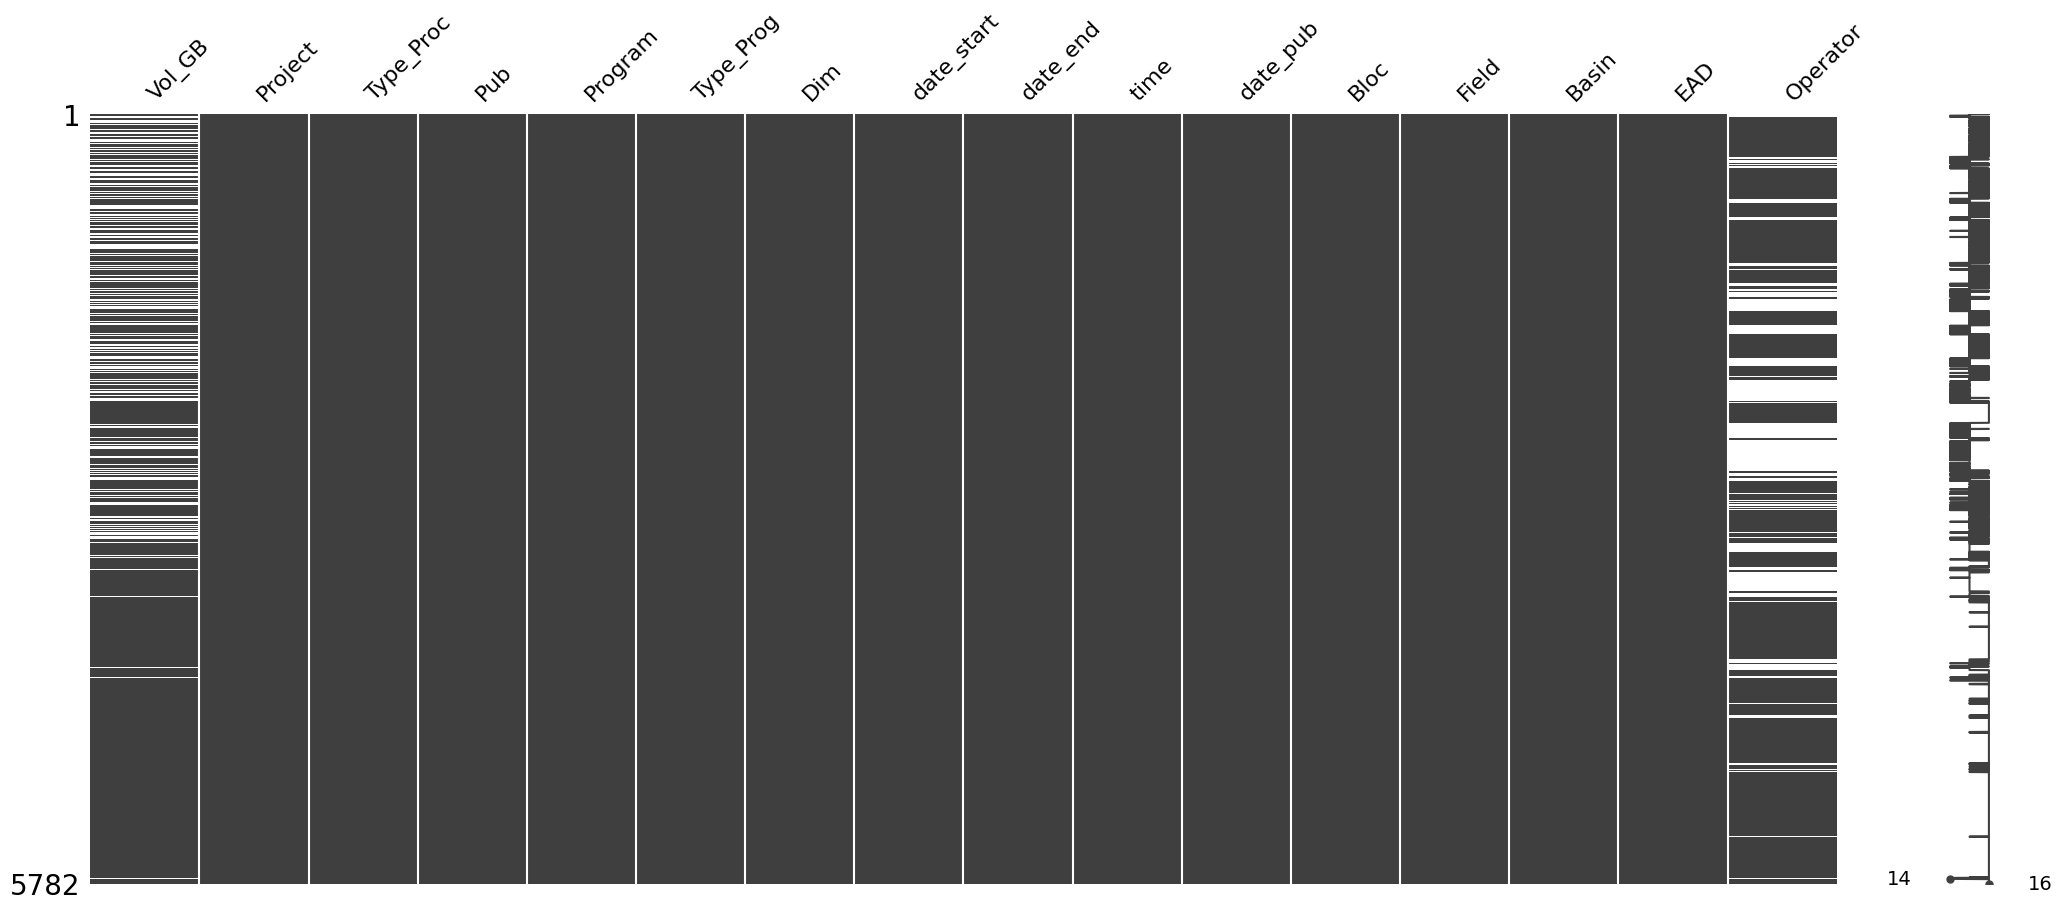

In [18]:
# removendo a coluna 'UDs'
programas.drop(['UDs'], axis=1, inplace= True)

# removendo as linhas com informações nulas de bacia
programas = programas[programas['Basin'].notna()]

# exibindo visualização matricial da nulidade do dataset
ms.matrix(programas)

<Axes: >

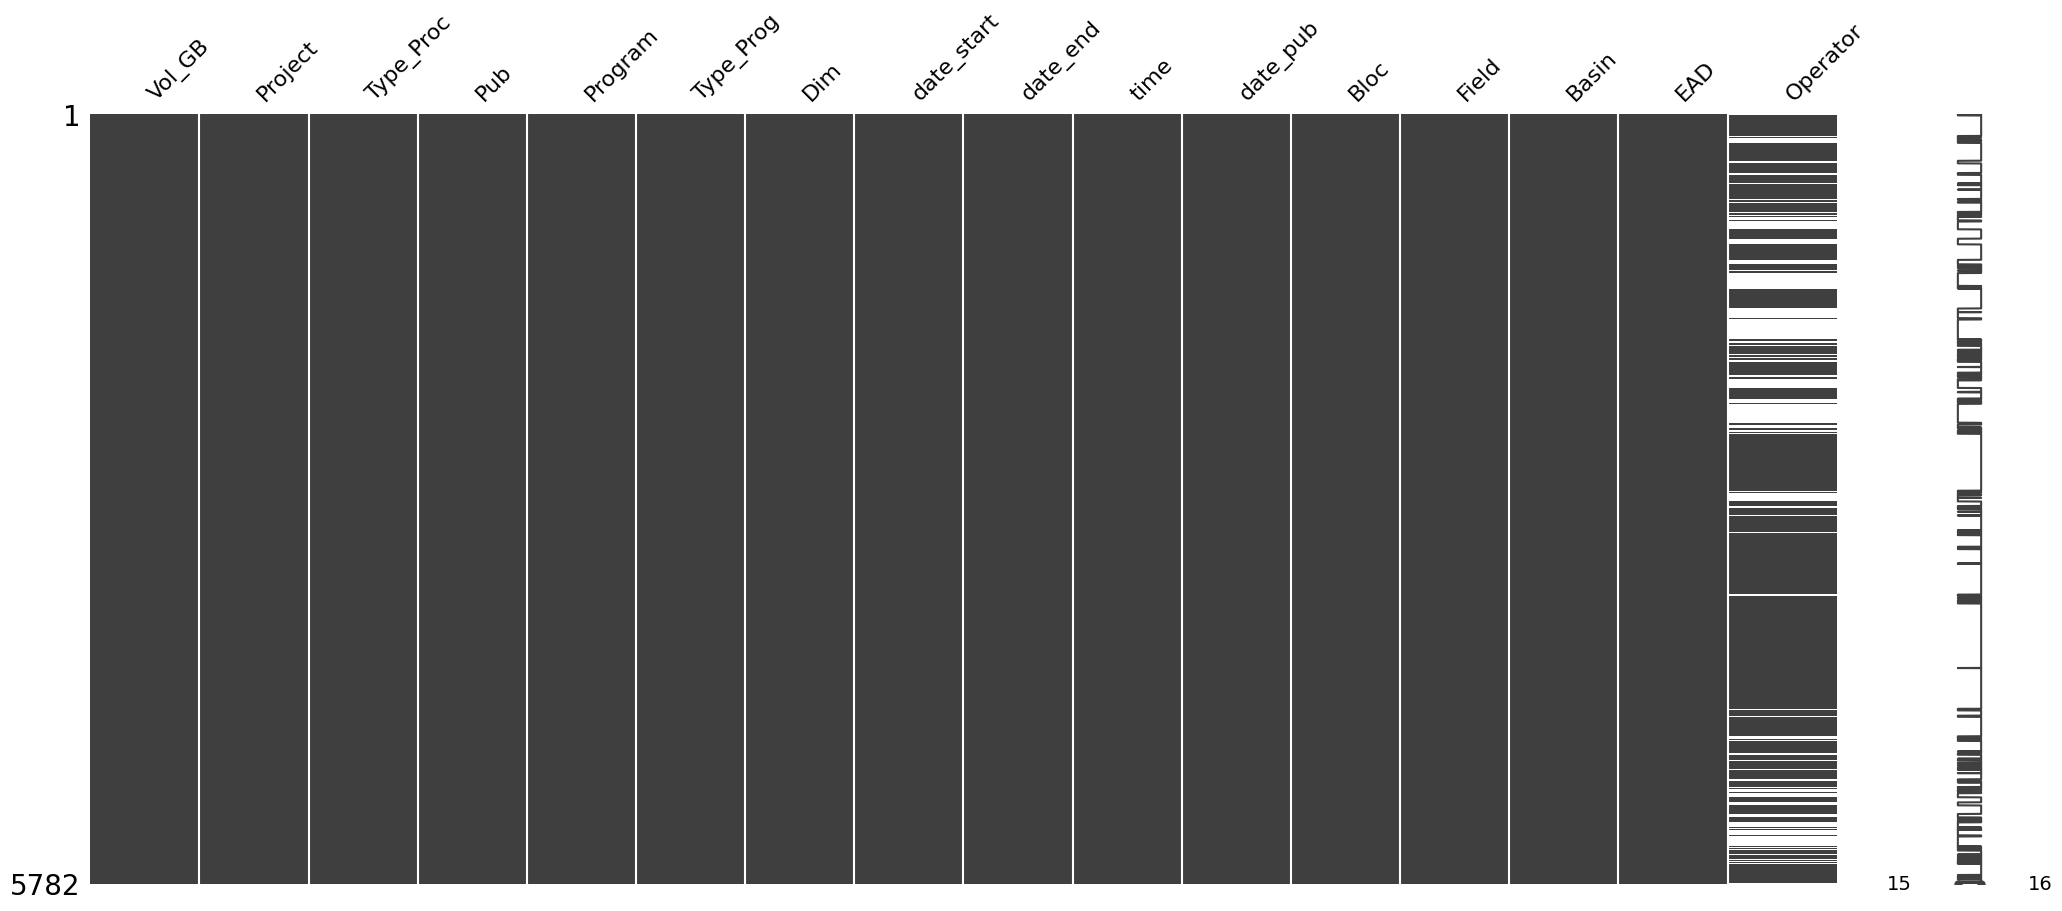

In [36]:
# Criando dataset alternativo sem a presença dos dados Brutos
sem_fd= programas.loc[programas['Type_Proc'] != 'Field Data']

# Criando dataset alternativo apenas com dados Brutos
com_fd= programas.loc[programas['Type_Proc'] == 'Field Data']

# substituindo os NaN de 'Vol_GB' pela média da coluna
sem_fd['Vol_GB'].fillna(sem_fd['Vol_GB'].mean(), inplace=True)
com_fd['Vol_GB'].fillna(com_fd['Vol_GB'].mean(), inplace=True)

# juntando os dataset novamente
programas= pd.concat([sem_fd,com_fd])


# exibindo visualização matricial da nulidade do dataset
ms.matrix(programas)

Para a resolução do problema será necessário quantificar algumas das informações do dataset atribuindo valores de acordo com o cenário atual do mercado de óleo e gás. Esses valores serão notas atribuídas a itens específicos como bacia sedimentar(Basin), dimensionalidade do dado (Dim), presença de uma empresa operadora (Operador), tipo de processamento (Type_Proc) e tempo de existência do processamento (time).